# Проект "Машинное обучение для текстов"  
# на тему "Построение модели машинного обучения для интернета магазина «Викишоп» с целью выявления токсичных комментариев"

**Описание проекта**  
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах.  
То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.   
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.  
Постройте модель со значением метрики качества F1 не меньше 0.75. 

**План выполнения проекта**

Сохранена предложенная структура проекта    
После каждого пункта следуют выводы и в заключение подводится общий итог

- 1 Подготовка данных
    - импорт библиотек, определение функций и глобальных параметров
    - открытие файла данных, беглый анализ датасета
- 2 Обучение моделей
    - генерация признаков
    - подбор методов предобработки и токенизации
    - первичный подбор модели в стиле LazyPredict
    - выбор основной модели и подбор гиперпараметров
    - проверка качества модели на тестовой выборке
- 3 Выводы
    - визуализация оценок качества модели
    - подведение итогов и общие выводы
- 4 Чек-лист проверки

## 1 Подготовка данных

**Импорт библиотек, определение функций и глобальных параметров**

In [1]:
import os
import phik
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from scipy.sparse import vstack

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression,  RidgeClassifier,  SGDClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords as nltk_stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
stopwords = list(set(nltk_stopwords.words('english')))

RANDOM_STATE = 42
pd.set_option('display.max_colwidth', None)
plt.rcdefaults()
plt.rc('font', size=6) 
plt.rcParams['figure.figsize'] = [8, 2]
plt.rcParams['figure.dpi'] = 150

In [2]:
# Загрузка данных

def load_df(file_name, sep=',', path='https://code.s3.yandex.net/datasets/', **params):
    pth1 = file_name
    pth2 = path + file_name

    if os.path.exists(pth1):
        return pd.read_csv(pth1, **params)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2, **params)
    else:
        print(f"Cannot find file {file_name} in the specified folders, trying remote")
        return pd.read_csv(pth2, **params)

In [3]:
# Настройка и предсказания модели

def model_fit_predict(model_name, model, subsets, verbose=True):
    X_train, y_train, X_valid, y_valid = subsets
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = round(time.time() - start)

    start = time.time()
    y_pred = model.predict(X_train)
    predict_train_time = round(time.time() - start) 
    f1_train = round(f1_score(y_train, y_pred),4)
    
    start = time.time()
    y_pred = model.predict(X_valid)
    predict_valid_time = round(time.time() - start) 
    f1_valid = round(f1_score(y_valid, y_pred),4)

    if verbose:
        print(f'{model_name} : F1 (train/valid): {f1_train}/{f1_valid}, time (fit/train/valid, s): {fit_time}/{predict_train_time}/{predict_valid_time}')

    params = [x for x in model.get_params().items() if str(x[1]).isnumeric()][:10]

    return [f1_train, f1_valid, fit_time, predict_train_time, predict_valid_time, params]

In [4]:
# Визуализация результатов и вывод метрик

def cm_estimator(estimator, X, y, more_text='', normalize='true'):
    disp = ConfusionMatrixDisplay.from_estimator(estimator, X, y, labels=estimator.classes_, normalize=normalize, cmap='Blues')
    fig = disp.figure_
    fig.set_figwidth(4)
    fig.set_figheight(4) 
    if more_text != '':
        more_text = ' ' + more_text
    fig.suptitle('Матрица ошибок' + more_text)
    plt.xlabel('Предсказания')
    plt.ylabel('Реальные значения')
    return disp


def tabulated_output(headers, data, first_col_as_index=True, title=None):
    if first_col_as_index:
        index = [x[0] for x in data]
        data = [x[1:] for x in data]
        index_name = headers[0]
        pdf = pd.DataFrame(data, columns = headers[1:], index=index)
        pdf.index.name= index_name 
    else:
        pdf = pd.DataFrame(data, columns = headers)
    if title:
        pdf.columns = pd.MultiIndex.from_product([[title], pdf.columns])
    return pdf


def print_classification_report(y_test, y_pred):
    cr = classification_report(y_test, y_pred, output_dict=True)
    res = []
    for x, y in cr.items():
        if x!='accuracy':
            res.append([x]+[z for z in y.values()])
        else:
            res.append(['accuracy', '', '', '', y])
    display(tabulated_output(['', 'precision ', 'recall', 'f1-score', 'support'], res))


def assess_f1(pipe, X_train, y_train, X_test, y_test):
    start = time.time()
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    pipeline_list = list(pipe.named_steps['columntransformer'].named_transformers_['pipeline'].named_steps.keys())
    column_tr_list = list(pipe.named_steps['columntransformer'].named_transformers_.keys())[-1]
    pipe_list = list(pipe.named_steps.keys())[-1]
    total_list = pipeline_list + [column_tr_list] + [pipe_list]
    print(f'{total_list}: f1: {round(f1_score(y_test, y_pred),4)}, time: {round(time.time() - start)} s')

In [5]:
# Разбиение выборки с предобработкой

def sampling(data, feature_list, target_col, preprocessor, verbose=True, test_size=0.2): # ups=1, downs=1, verbose=True, test_size=0.2):

    X_train, X_test, y_train, y_test = train_test_split(data[feature_list], data[target_col], random_state=RANDOM_STATE, test_size=test_size)
    if verbose:
        print_classes(X_train, y_train)
    X_train_transformed = preprocessor.fit_transform(X_train[feature_list]).astype(float)
    X_test_transformed = preprocessor.transform(X_test[feature_list]).astype(float)
    return  X_train_transformed, y_train, X_test_transformed, y_test

def print_classes(X, y):
    print(f'Размер выборок: {X.shape}, {y.shape}')
    print(f"Класс '0': {y.eq(0).sum()}, {round(1-y.mean(),2)}; класс '1': {y.eq(1).sum()}, {round(y.mean(),2)}")

In [6]:
# Предобработка текста

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None


def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


def stem_sentence(sentence):
    ps = PorterStemmer()
    words=[]
    for w in word_tokenize(sentence):
        try:
            words.append(ps.stem(w))
        except:
            pass #print('Ошибка Porter Stemmer: длина слова:', len(w))
    return " ".join(words)


def clean(text):
    text = re.sub(r"http\S+", " ", text) # urls
    text = re.sub(r"RT ", " ", text)        # RT
    text = re.sub(r"[^a-zA-Z\'\?\(\)\!\.\,\d\s]", " ", text) # некоторые специальные символы
    text = re.sub(r"[0-9]", " ", text)  # числа
    text = re.sub(r'\t', ' ', text)         # табуляции
    text = re.sub(r'\n', ' ', text)         # переносы строк
    text = re.sub(r"\s+", " ", text)    # лишние пробелы
    text = text.strip()
    return text


class Cleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(clean)


class LemmatizeSentence(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lemmatize_sentence)


class StemSentence(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(stem_sentence)

**Открытие файла данных, беглый анализ датасета**

In [7]:
global_start = time.time()
df = load_df('toxic_comments.csv', usecols=['text', 'toxic'])

df.info()
print('-'*35)
print(f'Пропусков: {df.isna().sum().sum()}')
print(f'Дубликатов: {df.duplicated().sum()}')
print(f'Распределение в таргете: {dict(Counter(df.toxic))}')
df.head()

Cannot find file toxic_comments.csv in the specified folders, trying remote
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
-----------------------------------
Пропусков: 0
Дубликатов: 0
Распределение в таргете: {0: 143106, 1: 16186}


,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Данные загружены успешно, датасет представляет собой столбец текстового признака на английском языке и столбец таргета, пропусков и дубликатов нет, в таргете наблюдается дисбаланс.

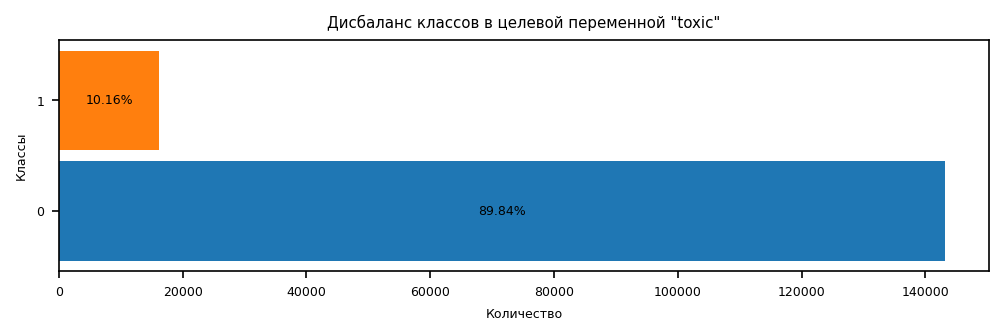

In [8]:
n, _, patches = plt.hist(bins=2, x=df.toxic, histtype='bar', orientation='horizontal', rwidth=0.9, align='left', range=(0,2))
patches[0].set_facecolor('C0')
patches[1].set_facecolor('C1')
plt.bar_label(patches, labels=[f'{x/sum(n):.2%}' for x in n], label_type='center')
plt.yticks([0,1])
plt.xlabel('Количество')
plt.ylabel('Классы')
plt.title('Дисбаланс классов в целевой переменной "toxic"');

## 2 Обучение моделей

Выделим тестовый датасет.

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

Воспользуемся библиотекой NLTK для генерации новых sentiment-признаков.

In [10]:
%%time
# Wall time ~ 1 min

sia = SentimentIntensityAnalyzer()
df_train['neg'], df_train['neu'], df_train['pos'], df_train['compound'] = zip(*df_train['text'].map(lambda x: sia.polarity_scores(x).values()))
df_test['neg'], df_test['neu'], df_test['pos'], df_test['compound'] = zip(*df_test['text'].map(lambda x: sia.polarity_scores(x).values()))

CPU times: total: 4.33 s
Wall time: 47.8 s


In [11]:
target = 'toxic'
num_features = [x for x in df_train.columns if x not in ['text', target]]
features = num_features + ['text']

Оценка отклика таргета.

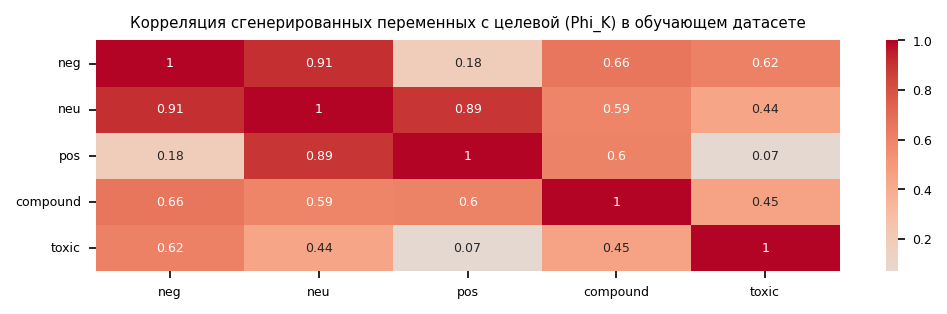

In [12]:
(
    sns.heatmap(df_train[num_features + [target]].phik_matrix(interval_cols=num_features+ [target]), cmap='coolwarm', center=0, annot=True)
        .set_title('Корреляция сгенерированных переменных с целевой (Phi_K) в обучающем датасете')
);

In [13]:
class_weight={1:0.7, 0:0.3}
models = [LogisticRegression(max_iter=3000, class_weight=class_weight, random_state=RANDOM_STATE), 
                SGDClassifier(eta0=0.1, alpha=1e-5, class_weight=class_weight, random_state=RANDOM_STATE),
                DummyClassifier(strategy='constant', random_state=RANDOM_STATE, constant=1)]

X_train, X_valid, y_train, y_valid = train_test_split(df_train[num_features], df_train[target], random_state=RANDOM_STATE)

,F1 score
model,
LogisticRegression,0.483854
SGDClassifier,0.439741
DummyClassifier,0.186584


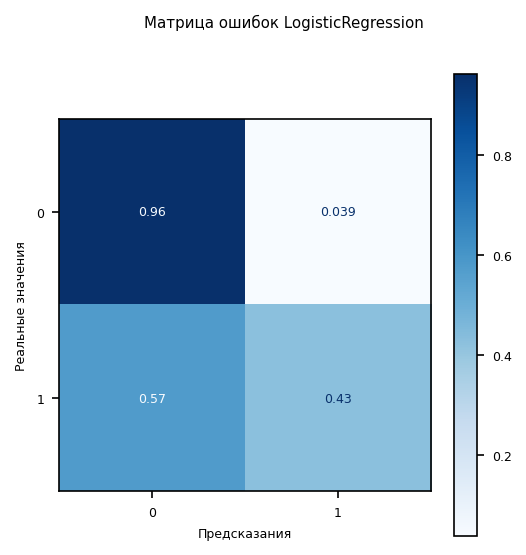

In [14]:
res = []
for model in models:
    model.fit(X_train, y_train)
    res.append([type(model).__name__, f1_score(y_valid, model.predict(X_valid))])

display(tabulated_output(['model', 'F1 score'], res))

clf = models[0]
clf.fit(X_train, y_train)
cm_estimator(clf, X_valid, y_valid, more_text=type(clf).__name__);

Новые признаки влияют заметнее, их можно использовать.    
Использование готового инструмента, обученного на близкую задачу (анализ тональности) использовать для построения признаков токсичности, возможно, привлекает для решения дополнительные данные со стороны, но при решении бизнес-задач воспользоваться готовой библиотекой - это самое быстрое и эффективное решение.

**Подбор методов предобработки и токенизации**

Предобработку текстовых данных проведем в три этапа: очистка данных от "мусора", токенизация, нормализация и кодирование текста.   
Проведем нормализацию сгенерированных количественных переменных (в основном из-за того, чтобы избавиться от отрицательных значений).

In [15]:
text_pipeline = make_pipeline(
    Cleaner(), 
    StemSentence(),
    TfidfVectorizer(stop_words=stopwords, analyzer='word', token_pattern=r'\w{1,}'),
    )

preprocessor = ColumnTransformer([
    ("text_preprocess", text_pipeline, "text"),
    ("num_preprocess", MinMaxScaler(), num_features)
    ], remainder='passthrough')

Перед началом обработки разобъем тренировочный датасет на обучающую и валидационную выборки (размер валидационной выборки по умолчанию 20%).

In [16]:
%%time
# Wall time: ~2 min

X_train, y_train, X_valid, y_valid = sampling(df_train, features, target, preprocessor)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

Размер выборок: (101946, 5), (101946,)
Класс '0': 91533, 0.9; класс '1': 10413, 0.1
CPU times: total: 19.8 s
Wall time: 1min 31s


((101946, 97740), (101946,), (25487, 97740), (25487,))

**Первичный подбор модели в стиле LazyPredict**

Протестируем подготовленные данные на простых быстрых моделях.  
(Модели деревьев решений, ближайших соседей в нашем случае работают очень медленно, если в методах векторизации   
не ограничивать количество переменных. Также не рассматриваем модели глубокого обучения.)

In [17]:
%%time
# Wall time: ~30 s

res=[]
columns=['model', 'train F1', 'valid F1', 'fit time', 'predict train time', 'predict valid time', 'numeric parameters']

subsets = X_train, y_train, X_valid, y_valid
models = [
    ('DummyClassifier', DummyClassifier(strategy='constant', constant = 1, random_state=RANDOM_STATE)),
    ('MultinomialNB', MultinomialNB(alpha=0.6)),
    ('ComplementNB', ComplementNB()), 
    ('NearestCentroid', NearestCentroid()),
    ('RidgeClassifier', RidgeClassifier(random_state=RANDOM_STATE)), 
    ('LogisticRegression', LogisticRegression(max_iter=3000, random_state=RANDOM_STATE)),
    ('SGDClassifier', SGDClassifier(alpha=1e-05, random_state=RANDOM_STATE)), 
    ('XGBClassifier', XGBClassifier(random_state=RANDOM_STATE)), 
    ('LGBMClassifier', LGBMClassifier(verbose=-1, random_state=RANDOM_STATE))
]

for model_name, model in models:
    result = model_fit_predict(model_name, model, subsets)
    res.append([model_name]+result)

tabulated_output(columns, res).sort_values(by='valid F1', ascending=False)

DummyClassifier : F1 (train/valid): 0.1854/0.1833, time (fit/train/valid, s): 0/0/0
MultinomialNB : F1 (train/valid): 0.4938/0.4511, time (fit/train/valid, s): 0/0/0
ComplementNB : F1 (train/valid): 0.6387/0.6057, time (fit/train/valid, s): 0/0/0
NearestCentroid : F1 (train/valid): 0.3885/0.387, time (fit/train/valid, s): 0/0/0
RidgeClassifier : F1 (train/valid): 0.8152/0.7197, time (fit/train/valid, s): 1/0/0
LogisticRegression : F1 (train/valid): 0.7746/0.749, time (fit/train/valid, s): 2/0/0
SGDClassifier : F1 (train/valid): 0.8279/0.7707, time (fit/train/valid, s): 0/0/0
XGBClassifier : F1 (train/valid): 0.8164/0.75, time (fit/train/valid, s): 17/0/0
LGBMClassifier : F1 (train/valid): 0.8011/0.766, time (fit/train/valid, s): 7/0/0
CPU times: total: 5min 28s
Wall time: 28.6 s


,train F1,valid F1,fit time,predict train time,predict valid time,numeric parameters
model,,,,,,
SGDClassifier,0.8279,0.7707,0,0,0,"[(max_iter, 1000), (n_iter_no_change, 5), (random_state, 42), (verbose, 0)]"
LGBMClassifier,0.8011,0.7660,7,0,0,"[(min_child_samples, 20), (n_estimators, 100), (num_leaves, 31), (random_state, 42), (subsample_for_bin, 200000), (subsample_freq, 0)]"
XGBClassifier,0.8164,0.7500,17,0,0,"[(random_state, 42)]"
LogisticRegression,0.7746,0.7490,2,0,0,"[(intercept_scaling, 1), (max_iter, 3000), (random_state, 42), (verbose, 0)]"
RidgeClassifier,0.8152,0.7197,1,0,0,"[(random_state, 42)]"
ComplementNB,0.6387,0.6057,0,0,0,[]
MultinomialNB,0.4938,0.4511,0,0,0,[]
NearestCentroid,0.3885,0.3870,0,0,0,[]
DummyClassifier,0.1854,0.1833,0,0,0,"[(constant, 1), (random_state, 42)]"


Самым быстрым и результативным оказался SGDClassifier. Выберем для дальнейшего использования первые две модели,   
а вместо XGBClassifier - LogisticRegression из-за хорошей скорости.  
  
На этом этапе можно модифицировать предобработчик текста (preprocessor), однако это тема достаточно обширная, чтобы протестировать много вариантов.  
Например, можно включить в соответствующие списки и оценить F1 в следующих вариациях:
  - Cleaner(): удалить разные сочетания символов, повторений, знаков препинания, регистр букв и т.д.
  - StemSentence(): протестировать также Lancaster Stemmer, Snowball Stemmer
  - протестировать векторизацию с различными N-граммами 
  - включить разбор синтаксиса и распознавание именованных сущностей (entity recognition)  
  - для уменьшения количества переменных использовать методы главных компонент (PCA, SVD)
    
Мы проверим только стемминг/лемматизацию и CountVectorizer/TfidfVectorizer (немного уменьшим количество выборки, до 50000).

In [18]:
%%time
# Wall time ~ 6 min

df_train_sample = df_train.sample(50000, random_state=RANDOM_STATE)

X_train_sample, X_valid_sample, y_train_sample, y_valid_sample = train_test_split(df_train_sample[features], df_train_sample[target], random_state=RANDOM_STATE, test_size=0.2)
model = SGDClassifier(alpha=1e-05, random_state=RANDOM_STATE)
params = {'stop_words':stopwords, 'analyzer':'word', 'token_pattern': r'\w{1,}'}

tokenizers = [StemSentence(), LemmatizeSentence()]
vectorizers = [CountVectorizer(**params), TfidfVectorizer(**params)]
scalers = [MinMaxScaler()]

for tokenizer in tokenizers:
    for vectorizer in vectorizers:
        for scaler in scalers:
            pipe = make_pipeline(
                                make_column_transformer(
                                        (make_pipeline(
                                                Cleaner(), 
                                                tokenizer, 
                                                vectorizer), 'text'), 
                                        (scaler, num_features), 
                                        remainder='passthrough'),  
                                model)
            assess_f1(pipe, X_train_sample, y_train_sample, X_valid_sample, y_valid_sample)

['cleaner', 'stemsentence', 'countvectorizer', 'minmaxscaler', 'sgdclassifier']: f1: 0.6817, time: 36 s
['cleaner', 'stemsentence', 'tfidfvectorizer', 'minmaxscaler', 'sgdclassifier']: f1: 0.7635, time: 36 s
['cleaner', 'lemmatizesentence', 'countvectorizer', 'minmaxscaler', 'sgdclassifier']: f1: 0.7204, time: 109 s
['cleaner', 'lemmatizesentence', 'tfidfvectorizer', 'minmaxscaler', 'sgdclassifier']: f1: 0.7488, time: 111 s
CPU times: total: 1min 16s
Wall time: 4min 53s


Оставляем второй вариант, показывающий, что более простое усечение слов и более точные веса tf-idf для нашего датасета работают несколько лучше.  

**Выбор основной модели и подбор гиперпараметров**  
  
Датасет большой, сосредоточимся только на настройках весов несбалансированного класса и настройке небольшого числа гиперпараметров.  

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[features], df_train[target], random_state=RANDOM_STATE)

TfidfVectorizer генерирует значения признака, используя аггрегированные значения, поэтому, во избежание target leakage, этот этап нужно перенести из пайплайна обработки в пайплайн обучения.

In [20]:
%%time
# Wall time ~ 3 min

text_pipeline = make_pipeline(
    FunctionTransformer(lambda x: x.apply(clean)), 
    FunctionTransformer(lambda x: x.apply(stem_sentence)),
    FunctionTransformer(lambda x: np.array(x).reshape(-1,1))
    )

preprocessor = ColumnTransformer(
    [
    ("num_preprocess", MinMaxScaler(), num_features),
    ("text_preprocess", text_pipeline, "text")
    ], 
    remainder='passthrough', verbose_feature_names_out=False)

X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns = X_train.columns)
X_valid = pd.DataFrame(preprocessor.transform(X_valid), columns = X_valid.columns)

CPU times: total: 28 s
Wall time: 1min 29s


In [21]:
%%time 
# Wall time ~ 3 min

model = Pipeline([('classifier', LogisticRegression())])

param_grid = [
    {'model': [LogisticRegression(random_state=RANDOM_STATE)],
     'model__solver': ['newton-cg', 'liblinear'],
     'model__C': [5, 10], 
     'model__class_weight': [{1:0.6, 0:0.4}, {1:0.7, 0:0.3}, {1:0.8, 0:0.2} ],
     },
    {'model': [SGDClassifier(random_state=RANDOM_STATE, loss='modified_huber')],
     'model__eta0':  [0.01, 0.1],
     'model__alpha': [1e-5], 
     'model__class_weight': [{1:0.6, 0:0.4}, {1:0.7, 0:0.3}, {1:0.8, 0:0.2}]
     },
]

vectorizer = ColumnTransformer([
    ("tfidf_vectorizer", TfidfVectorizer(stop_words=stopwords, analyzer='word', token_pattern=r'\w{1,}'), "text"),
    ], 
    remainder='passthrough', verbose_feature_names_out=False)

estimator = Pipeline([('vectorizer', vectorizer), ('model', model)])

grid_search = GridSearchCV(estimator, param_grid, scoring='f1', verbose=1, cv=2)
grid_search.fit(X_train, y_train)
print('\n=====Лучший результат: F1 = ', grid_search.best_score_)
print('Параметры модели: ', grid_search.best_params_)


Fitting 2 folds for each of 18 candidates, totalling 36 fits

=====Лучший результат: F1 =  0.7732702023657507
Параметры модели:  {'model': LogisticRegression(C=10, class_weight={0: 0.3, 1: 0.7}, random_state=42,
                   solver='newton-cg'), 'model__C': 10, 'model__class_weight': {1: 0.7, 0: 0.3}, 'model__solver': 'newton-cg'}
CPU times: total: 33.6 s
Wall time: 1min 53s


Классическая модель LogisticRegression лучше и быстрее. 

**Проверка качества модели на тестовой выборке**


In [22]:
X_train_final = pd.concat([X_train, X_valid])
y_train_final = pd.concat([y_train, y_valid])
X_test_final = pd.DataFrame(preprocessor.transform(df_test[features]), columns = features)
y_test_final = df_test[target]
subsets = X_train_final, y_train_final, X_test_final, y_test_final
print(f'Размеры обучающего и тестового датасетов: ', X_train_final.shape, y_train_final.shape, X_test_final.shape, y_test_final.shape)

Размеры обучающего и тестового датасетов:  (127433, 5) (127433,) (31859, 5) (31859,)


Модель выбрана, в обучающем датасете объединим тренировочную и валидационную выборки.    
Задаем полученные параметры (вместо loss='hinge' выберем 'modified_huber', который позволяет делать оценки вероятностей, нужные нам в дальнейшем).

In [23]:
model = grid_search.best_estimator_
model_fit_predict(type(model).__name__+ ' w/LogisticRegression', model, subsets);

Pipeline w/LogisticRegression : F1 (train/valid): 0.8918/0.7972, time (fit/train/valid, s): 12/6/1


Целевой показатель 0.75 достигнут, время настройки/предсказания модели минимальное.

## 3 Выводы
  
**Визуализация оценок качества модели**

In [24]:
y_pred_proba = model.predict_proba(X_test_final)[::,1]
predictions = model.predict(X_test_final)

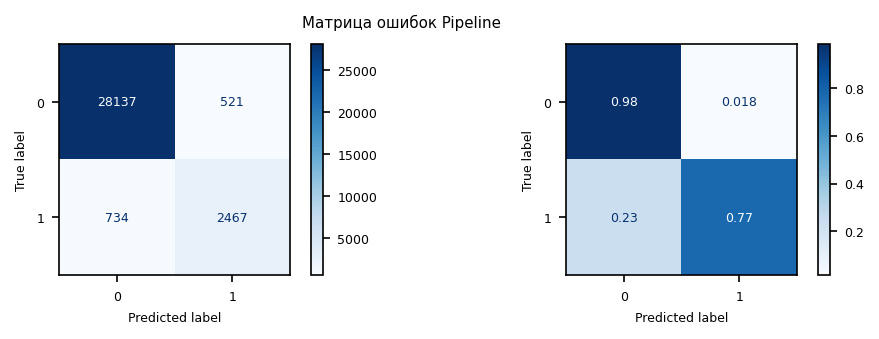

In [25]:
cm = confusion_matrix(y_test_final, predictions, labels=model.classes_)
cm_norm = confusion_matrix(y_test_final, predictions, labels=model.classes_, normalize='true')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Матрица ошибок ' + type(model).__name__)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(ax=ax1 , cmap='Blues')
ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=model.classes_).plot(ax=ax2, cmap='Blues');

In [26]:
print_classification_report(y_test_final, predictions)

,precision,recall,f1-score,support
,,,,
0,0.974577,0.98182,0.978185,28658.000000
1,0.825636,0.770697,0.797221,3201.000000
accuracy,,,,0.960608
macro avg,0.900106,0.876258,0.887703,31859.000000
weighted avg,0.959612,0.960608,0.960003,31859.000000


Модель определяет 77% всех токсичных комментариев.  

  
Построим стандартные для бинарной классификации кривые с оценкой порогов:  
  - чувствительность/специфичность - порог по геометрическому среднему
  - точность/полнота - порог по F1-метрике

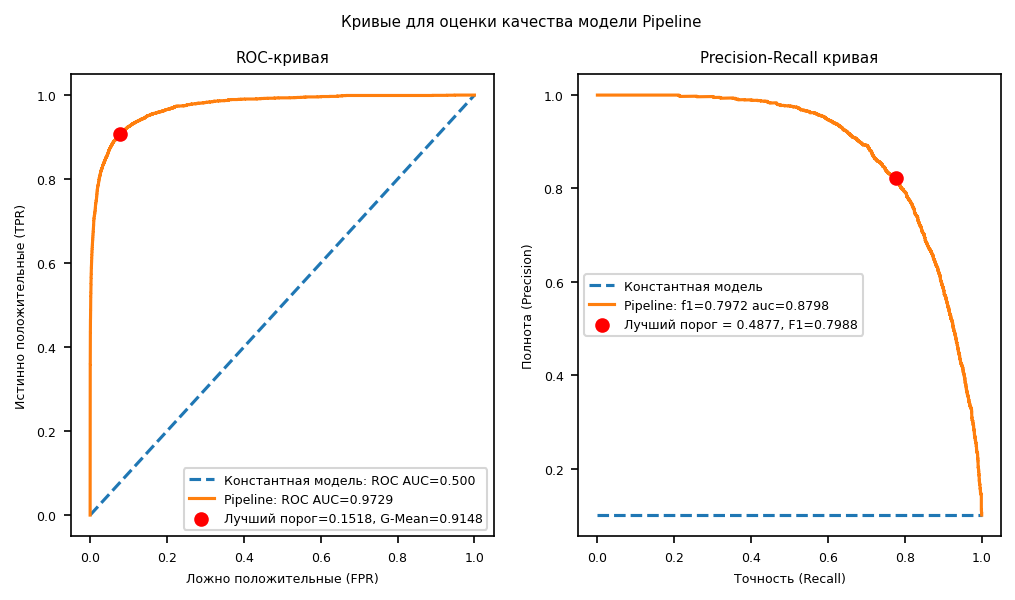

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Кривые для оценки качества модели ' + type(model).__name__)

ns_probs = [0] * len(y_test_final)
ns_auc = roc_auc_score(y_test_final, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test_final, ns_probs)
model_auc = roc_auc_score(y_test_final, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)

ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='Константная модель: ROC AUC=%.3f' % (ns_auc))
ax1.plot(fpr, tpr, label=f'{type(model).__name__}: ROC AUC={model_auc:.4}')
ax1.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Лучший порог={thresholds[ix]:.4}, G-Mean={gmeans[ix]:.4}', zorder=2)
ax1.set(xlabel='Ложно положительные (FPR)', ylabel='Истинно положительные (TPR)')
ax1.set_title('ROC-кривая')
ax1.legend()

precision, recall, thresholds = precision_recall_curve(y_test_final, y_pred_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
f1, auc_value = f1_score(y_test_final, predictions), auc(recall, precision)
no_skill = len(y_test_final[y_test_final==1]) / len(y_test_final)

ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Константная модель')
ax2.plot(recall, precision, label=f'{type(model).__name__}: f1={f1:.4} auc={auc_value:.4}')
ax2.scatter(recall[ix], precision[ix], marker='o', color='red', label=f"Лучший порог = {thresholds[ix]:.4}, F1={fscore[ix]:.4}", zorder=2)
ax2.set(xlabel='Точность (Recall)', ylabel='Полнота (Precision)')
ax2.set_title('Precision-Recall кривая')
ax2.legend()
plt.show()
#plt.tight_layout()

Попробуем также оценить постфактум правильность порога модели, а именно отличие от 0.5.

In [28]:
thresholds = np.arange(0, 1, 0.01)
scores = [f1_score(y_test_final, (y_pred_proba >= t).astype('int')) for t in thresholds]
ix = np.argmax(scores)
print(f'Threshold = {thresholds[ix]:.2f}, F-Score = {scores[ix]:.4f}')

Threshold = 0.49, F-Score = 0.7983


В завершение построим стандартное "облако слов", в нашем случае - токсичных.

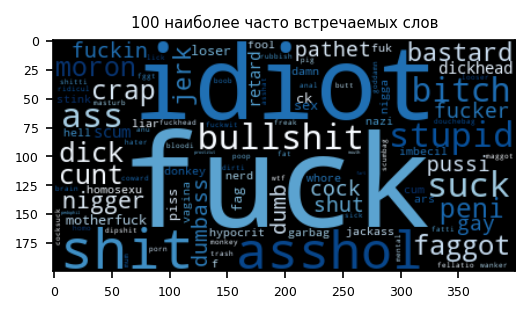

In [29]:
#words_list = preprocessor.transformers_[0][1].steps[2][1].get_feature_names_out()
words_list = model[0].transformers_[0][1].get_feature_names_out()
weights_list = model[1].coef_.flatten()[:-4]
weights = pd.DataFrame({'words': words_list, 'weights': weights_list}).sort_values(by='weights', ascending=False)[:100]
wc = WordCloud(background_color="black", colormap = 'Blues').generate_from_frequencies(dict(weights.values))
plt.imshow(wc, interpolation='bilinear')
plt.title('100 наиболее часто встречаемых слов');

**Подведение итогов и общие выводы**

**Итоги**  
  - заказчиком поставлена задача построения модели машинного обучения для выявления токсичных англоязычных комментариев со значением метрики качества F1 не меньше 0.75
  - данные загружены успешно, проведен краткий анализ, выявлен дисбаланс классов в целевой переменной
  - проведена генерация новых признаков на основе SentimentIntensityAnalyzer из библиотеки NLTK
  - выбраны методы предобработки текста PorterStemmer и TfidfVectorizer из библиотеки NLTK
  - основной моделью выбран SGDClassifier и произведен подбор параметров с учетом дисбаланса классов
  - произведена проверка качества модели на тестовой выборке и достигнута метрика F1 не менее 0.75
  - произведена визуализация результатов
  
**Выводы**  
  - данная модель подходит для решения поставленной задачи - выявление токсичных комментариев на английском языке с заданной метрикой
  - существует ряд возможностей для достижения лучших результатов:
    - использование других известных библиотек для предобработки текста (TextBlob, CoreNLP, Gensim, spaCy и т.д.), в каждой из которых присутствуют свои средства нормализации и векторизации
    - более полный анализ теста, включая изучение синтаксиса и распознание именованных сущностей
    - использование более современных мощных алгоритмов нейронных сетей